In [1]:
import pandas as pd
import numpy as np
import random
import os

In [2]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

In [3]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(42) # Seed 고정

In [4]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

trainval_x = train.drop(columns=['ID', 'Income'])
trainval_y = train['Income']

test_x = test.drop(columns=['ID'])

In [5]:
encoding_target = list(trainval_x.dtypes[trainval_x.dtypes == "object"].index)

for i in encoding_target:
    le = LabelEncoder()
    
    # train과 test 데이터셋에서 해당 열의 모든 값을 문자열로 변환
    trainval_x[i] = trainval_x[i].astype(str)
    test_x[i] = test_x[i].astype(str)
    
    le.fit(trainval_x[i])
    trainval_x[i] = le.transform(trainval_x[i])
    
    # test 데이터의 새로운 카테고리에 대해 le.classes_ 배열에 추가
    for case in np.unique(test_x[i]):
        if case not in le.classes_: 
            le.classes_ = np.append(le.classes_, case)
    
    test_x[i] = le.transform(test_x[i])

In [6]:
train_idx, val_idx = train_test_split(np.arange(len(trainval_x)), test_size=0.2)

train_x = trainval_x.iloc[train_idx]
train_y = trainval_y.iloc[train_idx]

val_x = trainval_x.iloc[val_idx]
val_y = trainval_y.iloc[val_idx]

In [7]:
model = GradientBoostingRegressor(max_depth=7)
model.fit(train_x, train_y)

GradientBoostingRegressor(max_depth=7)

In [8]:
train_y_hat = model.predict(train_x)
val_y_hat = model.predict(val_x)

print(f'train error : {mean_squared_error(train_y, train_y_hat) ** 0.5}')
print(f'val error : {mean_squared_error(val_y, val_y_hat) ** 0.5}')

train error : 449.2592226906044
val error : 606.1807922704844


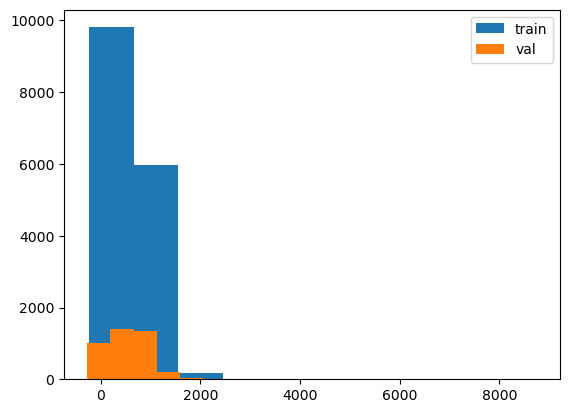

In [9]:
import matplotlib.pyplot as plt

plt.hist(train_y_hat, label='train')
plt.hist(val_y_hat, label='val')
plt.legend()

In [10]:
train_y_hat_post = np.where(train_y_hat < 0, 0, train_y_hat)
val_y_hat_post = np.where(val_y_hat < 0, 0, val_y_hat)

print(f'train error (post-processing) : {mean_squared_error(train_y, train_y_hat_post) ** 0.5}')
print(f'val error (post-processing) : {mean_squared_error(val_y, val_y_hat_post) ** 0.5}')

train error (post-processing) : 449.20676229420377
val error (post-processing) : 606.0706819879751


In [11]:
submission = pd.read_csv('data/sample_submission.csv')
submission

,ID,Income
0,TEST_0000,0
1,TEST_0001,0
2,TEST_0002,0
3,TEST_0003,0
4,TEST_0004,0
...,...,...
9995,TEST_9995,0
9996,TEST_9996,0
9997,TEST_9997,0
9998,TEST_9998,0


In [12]:
pred = model.predict(test_x)
# pred = np.where(pred < 0, 0, pred)

In [13]:
submission['Income'] = pred
submission

,ID,Income
0,TEST_0000,-10.966243
1,TEST_0001,-27.829576
2,TEST_0002,412.647628
3,TEST_0003,655.547179
4,TEST_0004,2.525686
...,...,...
9995,TEST_9995,877.416364
9996,TEST_9996,819.570314
9997,TEST_9997,373.806124
9998,TEST_9998,3.877698


In [15]:
os.makedirs('submission', exist_ok=True)
submission.to_csv('submission/baseline.csv', index=False)
# submission.to_csv('submission/baseline_post.csv')